# $\textit{Detección de ondas gravitatorias}$
$\textit{Estimación Espectral No Paramétrica}$

In [6]:
#En ppio hay que elegir entre 32sec • 4KHz o 4096sec • 4KHz. Esto porque el evento esta alrededor de los 2Khz.
#Ademas, usamos el dataset de 4096 seg porque el ruido es localmente estacionario (hay que probarlo).

In [1]:
%matplotlib ipympl
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

In [2]:
sns.set_theme()

In [3]:
# these 4096 second files are useful for computing more accurate psds
largeFilenamePart = {'GW150914': 'GWOSC_4KHZ_R1-1126257415-4096.hdf5'}
fn_H1 = './Data/H-H1_' + largeFilenamePart['GW150914']
fn_L1 = './Data/L-L1_' + largeFilenamePart['GW150914']

# this is the approximate event time which is used in the papers
time_center = 1126259462

# get sample rate from the H1 data file
with h5py.File(fn_H1, 'r') as hdf_file:
    dt = hdf_file['strain/Strain'].attrs['Xspacing']
fs = int(1.0/dt)
print("Using sample rate of {0} Hz found in file: {1}".format(fs, fn_H1))

Using sample rate of 4096 Hz found in file: ./Data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


In [4]:
import readligo as rl
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

In [11]:
len(strain_H1)

16777216

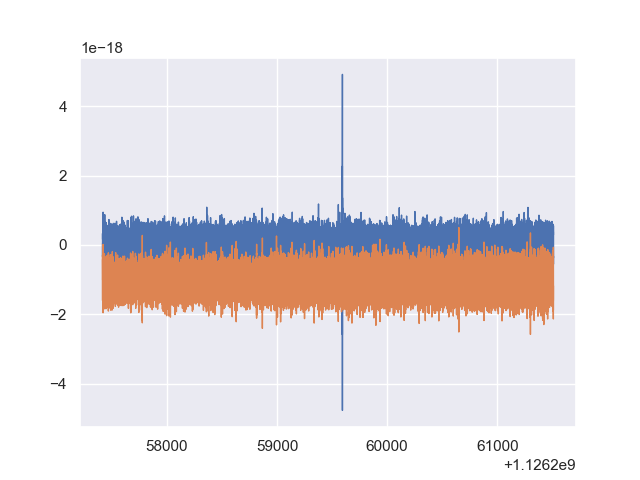

In [12]:
plt.plot(time_H1, strain_H1, linewidth=1)
plt.plot(time_L1, strain_L1, linewidth=1)

In [5]:
indxt_around_H1 = np.where((time_H1 >= time_center - 2) & (time_H1 < time_center + 2))
indxt_around_L1 = np.where((time_L1 >= time_center - 2) & (time_L1 < time_center + 2))

In [14]:
indxt_around_L1

(array([8376320, 8376321, 8376322, ..., 8392701, 8392702, 8392703],
       dtype=int64),)

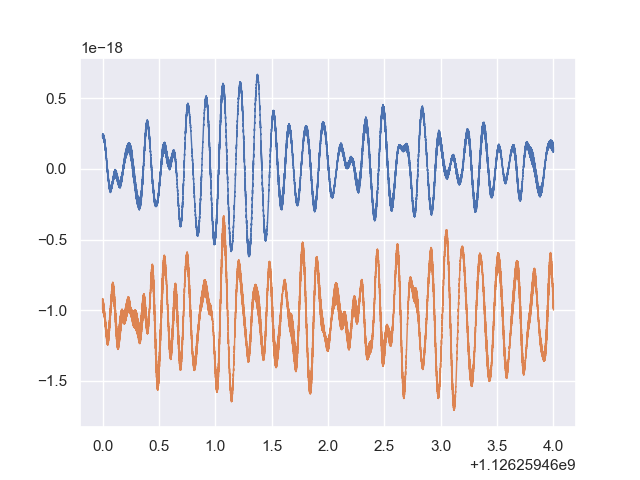

In [15]:
plt.figure()
plt.plot(time_H1[indxt_around_H1], strain_H1[indxt_around_H1], linewidth=1)
plt.plot(time_L1[indxt_around_L1], strain_L1[indxt_around_L1], linewidth=1)

# $\textit{Elegimos la ventana}$

In [16]:
from numpy.fft import fft, rfft
from numpy.fft import fftshift, fftfreq, rfftfreq
from scipy import signal as sg
from scipy.interpolate import interp1d

In [17]:
N = 4096
n = np.linspace(0,N-1,N)

SquareW = sg.windows.boxcar(N) #Square window
TriangW = sg.windows.triang(N) #Triangular window
BlkHarrW = sg.windows.blackmanharris(N)
ParzenW = sg.windows.parzen(N)
kaiserW = sg.windows.kaiser(N, 0.9)
tukeyW = sg.windows.tukey(N, 0.9)   # 

currWindow = ParzenW #Choose window

C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_8424\3376354181.py:8: RuntimeWarning: divide by zero encountered in log10
  response = 20*np.log10(np.abs(fftshift(A / abs(A).max())))


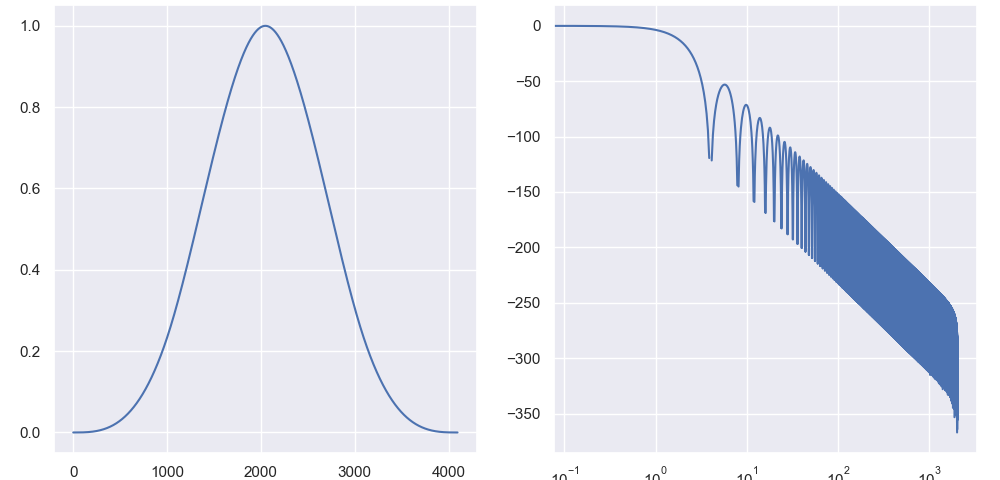

In [18]:
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0)
fig.set_figwidth(10)


A = fft(currWindow, N*8) / (N/2.0)
freq = fftshift( fftfreq(N*8, 1/fs))
response = 20*np.log10(np.abs(fftshift(A / abs(A).max())))


axs[0].set_title("Window")
axs[0].plot(currWindow)

axs[1].set_title("Frec. response")
axs[1].plot(freq, response)
axs[1].set_xscale('log')

# $\textit{Agarramos los datos sin el evento en ventanas}$

In [7]:

#Getting a neighbourhood of the event
strain_H1_after_noise = strain_H1[indxt_around_H1[0][-1]+1:]
strain_L1_after_noise = strain_L1[indxt_around_L1[0][-1]+1:]
strain_H1_before_noise = strain_H1[:indxt_around_H1[0][0]]
strain_L1_before_noise = strain_L1[:indxt_around_L1[0][0]]

getChuncks = lambda lst, K: [lst[i:i + K] for i in range(0, len(lst), K)][:-1]


In [20]:
len(getChuncks(strain_H1_after_noise, 100))

83845

# $\textit{Calculamos la PSD}$

In [13]:
def PSD(seq):
    rv = sg.correlate(seq, seq, mode="same")/N
    rx = rfft(rv) / (len(rv)/2.0)
    Rx = np.abs(rx)
    freq = rfftfreq(len(rv), 1/fs)
    return freq, Rx

NameError: name 'N' is not defined

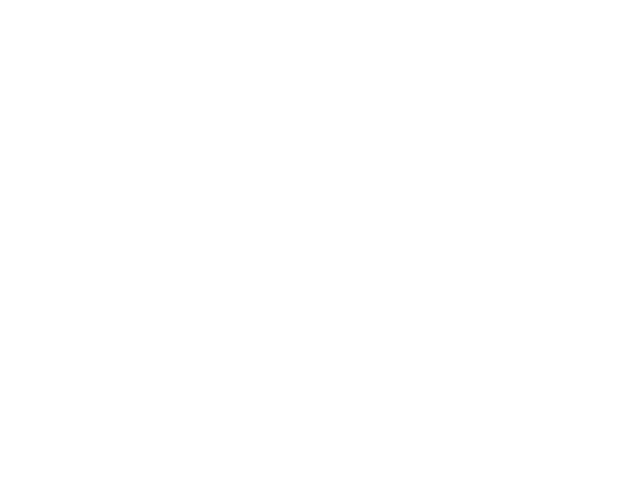

In [14]:
plt.figure()
rv = sg.correlate(strain_H1_after_noise, strain_H1_after_noise, mode="full")/N
lags = sg.correlation_lags(len(strain_H1_after_noise), len(strain_H1_after_noise), mode ="full")
plt.plot(lags, rv)


Esta autocorrelacion se realiza a traves del camino de la fft utilizando todas las muestras presentes luego del evento del dataset de 4096 segundos. Se puede ver que la correlacion es mas alta dentro de un intervalo de aproximadamente 30 seg y luego se achica y parece permanecer con una amplitud mas pequeña en comparacion con el centro. Esto no necesariamente indica que las muestras sean poco correlacionadas en ventanas de 30 seg ya que no se puede asegurar la estacionaridad de la señal en el intervalo de tiempo utilizado. En caso de que fuera estacionario, este resultado es evidencia de que para intervalos de mas de 30 seg la correlacion es bastante menor.

a) Se utilizó N = 4096 ya que 

(10, 512)

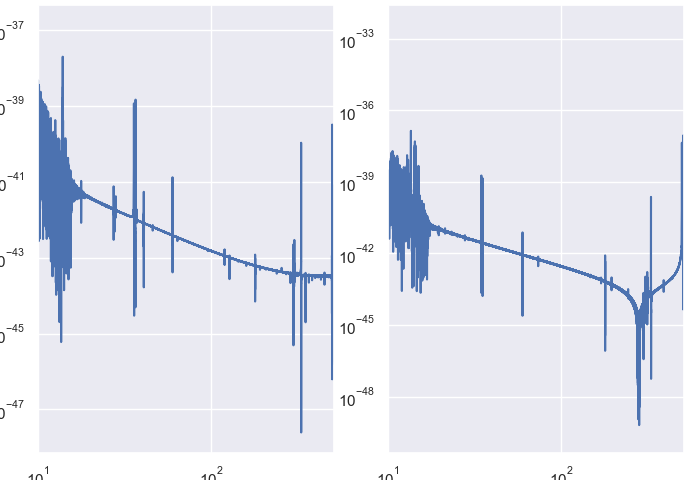

In [21]:
psd_freq1, psd1 = PSD(strain_H1_after_noise)
psd_freq2, psd2 = PSD(strain_L1_after_noise)

fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0)
fig.set_figwidth(7)

axs[0].set_title("PSD H1")
axs[0].plot(psd_freq1, psd1)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('Freq [Hz]')
axs[0].set_xlabel('PSD')
axs[0].set_xlim(10, 512)

axs[1].set_title("PSD L1")
axs[1].plot(psd_freq2, psd2)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Freq [Hz]')
axs[1].set_xlabel('PSD')
axs[1].set_xlim(10, 512)

# $\textit{Periodogram Averaging}$

In [25]:
def periodogram_averaging(data, seg_size, padding_multiplier, window):
    wind = window(seg_size)
    dataChunks = getChuncks(data, seg_size)*wind
    fftwindowSize = seg_size*padding_multiplier
    freqs = rfftfreq(fftwindowSize, 1/fs)
    periodogram = np.zeros(len(freqs))
    for i in range(len(dataChunks)):
        # Se van agregando al promediado los periodogramas de cada bloque calculado a partir de la FFT del señal en el tiempo
        periodogram = periodogram + np.abs(rfft(dataChunks[i], fftwindowSize)*2/fftwindowSize)**2/(fftwindowSize*len(dataChunks))   

    return freqs, periodogram, len(dataChunks)


## H1

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


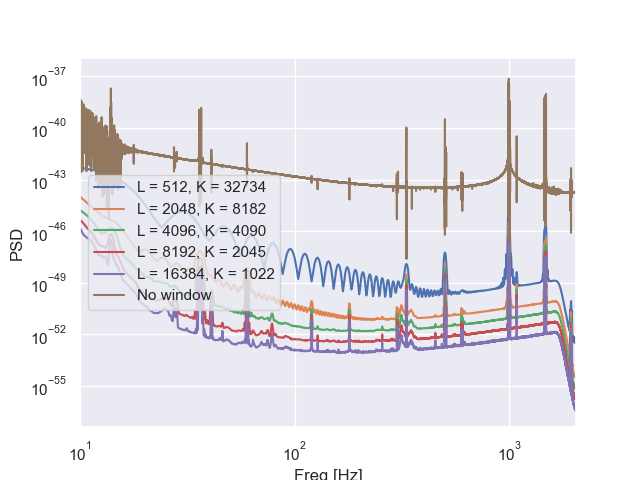

In [26]:
plt.figure()
for size in [512, 2048, 4096, 8192, 16384]:
    window = sg.windows.bartlett
    freqs, after_preiodogram, Kaf = periodogram_averaging(strain_H1_after_noise, size, 4, window)
    freqs, bf_preiodogram, Kbf = periodogram_averaging(strain_H1_before_noise, size, 4, window)
    mean_periodogram = (after_preiodogram + bf_preiodogram)/2
    plt.plot(freqs, mean_periodogram, label=f"L = {size}, K = {Kaf + Kbf}")

plt.plot(psd_freq, psd, label="No window")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, fs/2)
plt.legend()

In [27]:
size = 8192
window = sg.windows.bartlett
freqs, after_preiodogram, Kaf = periodogram_averaging(strain_H1_after_noise, size, 4, window)
paH1freqs, bf_preiodogram, Kbf = periodogram_averaging(strain_H1_before_noise, size, 4, window)
Rxpa_estH1 = (after_preiodogram + bf_preiodogram)/2

## L1

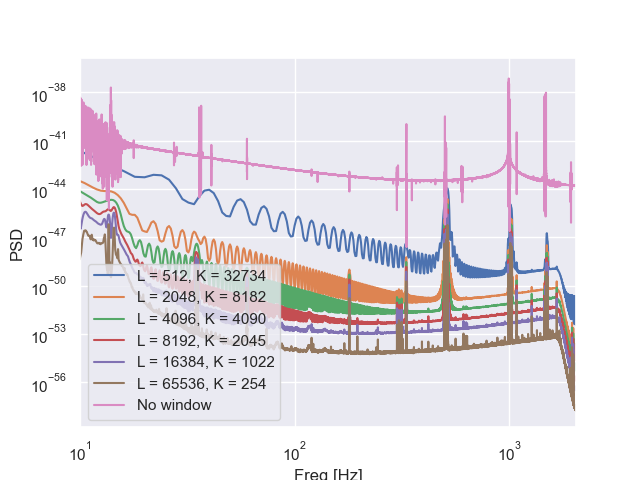

In [28]:
plt.figure()
for size in [512, 2048, 4096, 8192, 16384, 2**16]:
    window = sg.windows.bartlett
    freqs, after_preiodogram, Kaf = periodogram_averaging(strain_L1_after_noise, size, 4, window)
    freqs, bf_preiodogram, Kbf = periodogram_averaging(strain_L1_before_noise, size, 4, window)
    mean_periodogram = (after_preiodogram + bf_preiodogram)/2
    plt.plot(freqs, mean_periodogram, label=f"L = {size}, K = {Kaf + Kbf}")

plt.plot(psd_freq, psd, label="No window")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, fs/2)
plt.legend()

In [29]:
size = 512
window = sg.windows.bartlett
freqs, after_preiodogram, Kaf = periodogram_averaging(strain_L1_after_noise, size, 4, window)
paL1freqs, bf_preiodogram, Kbf = periodogram_averaging(strain_L1_before_noise, size, 4, window)
Rxpa_estL1 = (after_preiodogram + bf_preiodogram)/2

# $\textit{Periodogram Smoothing}$

## L1

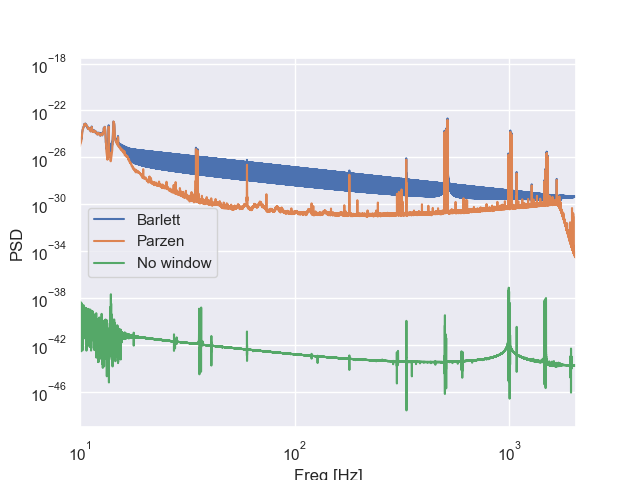

In [30]:
data_lenght = len(strain_L1_after_noise)
data_window = sg.windows.tukey(data_lenght, 1./4)
data = strain_L1_after_noise[:data_lenght] * data_window

lags2get = fs*30
window_size = lags2get*2+1

rx_full = sg.correlate(data, data)

rx = rx_full[data_lenght-lags2get: data_lenght+lags2get+1]
window1 = sg.windows.bartlett(window_size)
window2 = sg.windows.parzen(window_size)
vn1 = rx*window1
vn2 = rx*window2

Rxps_estL1barlet = np.abs(rfft(vn1))*window_size/2
Rxps_estL1parzen = np.abs(rfft(vn2))*window_size/2
psL1freqs = rfftfreq(window_size, 1/fs)

plt.figure()

plt.plot(psL1freqs, Rxps_estL1barlet, label="Barlett")
plt.plot(psL1freqs, Rxps_estL1parzen, label="Parzen")
plt.plot(psd_freq, psd, label="No window")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, fs/2)
plt.legend()




## H1

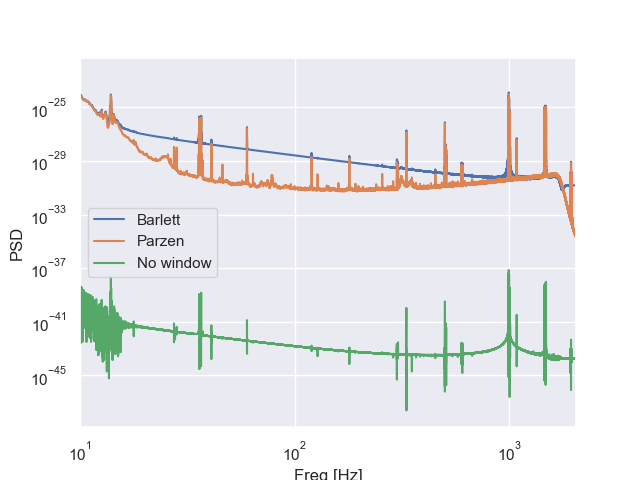

In [31]:
data_lenght = len(strain_H1_before_noise)
data_window = sg.windows.tukey(data_lenght, 1./4)
data = strain_H1_before_noise[:data_lenght] * data_window

lags2get = fs*20
window_size = lags2get*2+1

rx_full = sg.correlate(data, data)

rx = rx_full[data_lenght-lags2get: data_lenght+lags2get+1]
window1 = sg.windows.bartlett(window_size)
window2 = sg.windows.parzen(window_size)
vn1 = rx*window1
vn2 = rx*window2

Rxps_estH1barlet = np.abs(rfft(vn1))*window_size/2
Rxps_estH1parzen = np.abs(rfft(vn2))*window_size/2
psH1freqs = rfftfreq(window_size, 1/fs)

plt.figure()

plt.plot(psH1freqs, Rxps_estH1barlet, label="Barlett")
plt.plot(psH1freqs, Rxps_estH1parzen, label="Parzen")
plt.plot(psd_freq, psd, label="No window")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, fs/2)
plt.legend()


# Comparativa

# Filtrado

In [32]:
# Creditos: https://gwosc.org/tutorials/

# La funcion de whitening que utilizan escala el espectro de la señal por 1/sqrt(PSD) para blanquear el ruido sin modificar la fase de la señal.

def whiten(strain, dt, psd_interp, phase_shift=0, time_shift=0):
    """Whitens strain data given the psd and sample rate, also applying a phase
    shift and time shift.

    Args:
        strain (ndarray): strain data
        interp_psd (interpolating function): function to take in freqs and output 
            the average power at that freq 
        dt (float): sample time interval of data
        phase_shift (float, optional): phase shift to apply to whitened data
        time_shift (float, optional): time shift to apply to whitened data (s)
    
    Returns:
        ndarray: array of whitened strain data
    """
    Nt = len(strain)
    # take the fourier transform of the data
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by square root of psd, then
    # transform back, taking care to get normalization right.
    hf = np.fft.rfft(strain)
    
    # apply time and phase shift
    hf = hf * np.exp(-1.j * 2 * np.pi * time_shift * freqs - 1.j * phase_shift)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(psd_interp(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

def bandpass(fl, fh, data):
    b, a = sg.butter(4, [fl, fh], btype='bandpass', fs=fs)
    return sg.filtfilt(b, a, data)

In [33]:


dataH1 = strain_H1[indxt_around_H1]
dataL1 = strain_L1[indxt_around_L1]

L1_psd_interp = lambda x: np.interp(x, paL1freqs, Rxpa_estL1)
H1_psd_interp = lambda x: np.interp(x, psH1freqs, Rxps_estH1barlet)

whitened_dH1 = whiten(dataH1, 1/fs, H1_psd_interp)
whitened_dL1 = whiten(dataL1, 1/fs, L1_psd_interp)

filteredH1 = bandpass(35, 400, whitened_dH1)
filteredL1 = bandpass(35, 400, whitened_dL1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


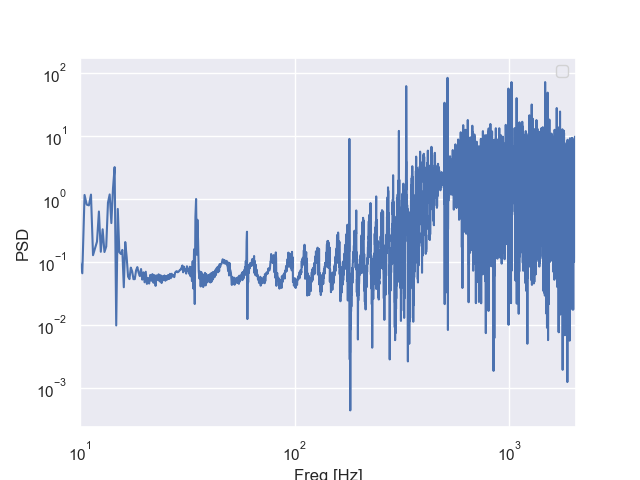

In [34]:
f, p = PSD(whitened_dL1)
plt.figure()
plt.plot(f, p)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, fs/2)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


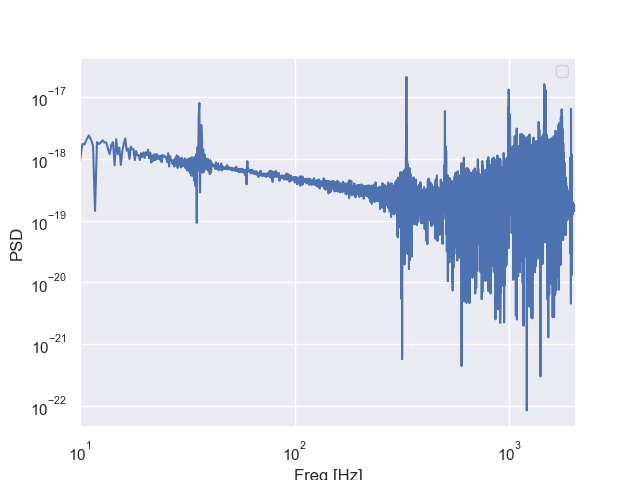

In [35]:
f, p = PSD(whitened_dH1)
plt.figure()
plt.plot(f, p)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, fs/2)
plt.legend()

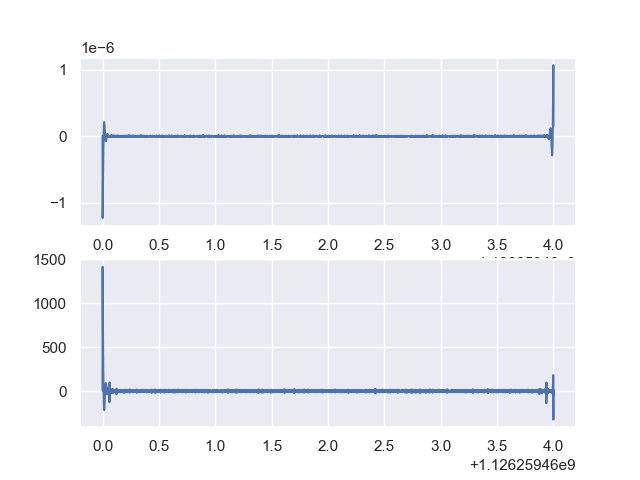

In [36]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(time_H1[indxt_around_H1], filteredH1)
plt.subplot(2, 1, 2)
plt.plot(time_L1[indxt_around_L1], filteredL1)

In [37]:
ipd.Audio(filteredL1, rate=fs)

# $\textit{Test de estacionaridad}$

# H1

In [11]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller

for i in range(0, len(strain_H1_after_noise), len(strain_H1_after_noise)//200):
    result = adfuller(strain_H1_after_noise[i:i+len(strain_H1_after_noise)//200])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.101425
p-value: 0.966158
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


KeyboardInterrupt: 